In [243]:
from qiskit import *
from torchvision import datasets, transforms
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, normalize
from qiskit.circuit import ParameterVector, Parameter
from qiskit.algorithms.optimizers import SPSA, ADAM, COBYLA
from qiskit import execute
from qiskit.providers.aer import AerSimulator
from qiskit.quantum_info import Statevector
from sklearn.decomposition import PCA

In [407]:
# Concentrating on the first 100 samples
n_samples = 50

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))
# Leaving only labels 0 and 1
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples],
                np.where(X_train.targets == 1)[0][:n_samples])

x_train = np.array([X_train[i][0].numpy() for i in idx])
y_train = np.array([X_train[i][1] for i in idx])

x_train, y_train = shuffle(x_train, y_train, random_state=42)

In [408]:
n_samples = 10

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

x_test = np.array([X_test[i][0].numpy() for i in idx]).reshape(-1,h,h)
y_test = np.array([X_test[i][1] for i in idx])

x_test, y_test = shuffle(x_test, y_test, random_state=42)

In [409]:
print(x_train.shape)
print(x_test.shape)

h = x_train.shape[2]
w = x_train.shape[3]

x_train = x_train.reshape(-1,h,w)
x_test = x_test.reshape(-1,h,w)

print(x_train.shape)
print(x_test.shape)

(100, 1, 28, 28)
(20, 28, 28)
(100, 28, 28)
(20, 28, 28)


In [410]:
def display_images(x, y):
    n_samples_show = 10
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

    while n_samples_show > 0:
        image, target = x[n_samples_show], y[n_samples_show]

        axes[n_samples_show - 1].imshow(image, cmap='gray')
        axes[n_samples_show - 1].set_xticks([])
        axes[n_samples_show - 1].set_yticks([])
        axes[n_samples_show - 1].set_title(format(target))

        n_samples_show -= 1

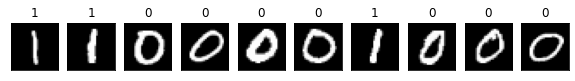

In [411]:
display_images(x_train, y_train)

In [412]:
x_train = x_train.reshape(-1,h*w)
x_test = x_test.reshape(-1,h*w)

In [413]:
n_components = 16
pca = PCA(n_components)
pca.fit(x_train)
print("Cumulative sum for train:", np.cumsum(pca.explained_variance_ratio_ * 100)[-1])
x_train = pca.transform(x_train)

pca.fit(x_test)
print("Cumulative sum for test:", np.cumsum(pca.explained_variance_ratio_ * 100)[-1])
x_test = pca.transform(x_test)

Cumulative sum for train: 83.053406
Cumulative sum for test: 98.82273


In [414]:
x_train = normalize(x_train)
x_test = normalize(x_test)

In [415]:
threshold = 0

x_train = np.array(x_train > threshold, dtype=np.float32)
x_test = np.array(x_test > threshold, dtype=np.float32)

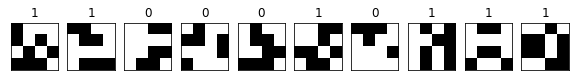

In [416]:
display_images(x_train.reshape(-1,4,4),y_test)

In [417]:
print(x_train.shape)
print(x_test.shape)
print(x_train.max(),x_train.min())

(100, 16)
(20, 16)
1.0 0.0


In [418]:
def cirq_layer(qc, readout, data_qubits, gate_name):
    theta_list = ParameterVector('θ' + gate_name, length=len(data_qubits))
    if gate_name == 'xx':
        for i in data_qubits:
            qc.rxx(theta_list[i-1], i, readout)
    elif gate_name == 'zz':
        for i in data_qubits:
            qc.rzz(theta_list[i-1], i, readout)
    else:
        raise ValueError("gate name must be either xx or zz")
    return qc

In [423]:
n = n_components + 1
backend = AerSimulator()

# Data encoding circuit
in_thetas = ParameterVector('θ_in', length=n)
feature_map  = QuantumCircuit(n,1)
for i in range(1,n):
    feature_map.rx(in_thetas[i], i)

# variational circuit
var_form = QuantumCircuit(n,1)
var_form.x(0)
var_form.h(0)
var_form = cirq_layer(var_form, 0, range(1,n), 'xx')
var_form = cirq_layer(var_form, 0, range(1,n), 'zz')
var_form.h(0)

circuit = feature_map.compose(var_form)
circuit.measure(0,0)

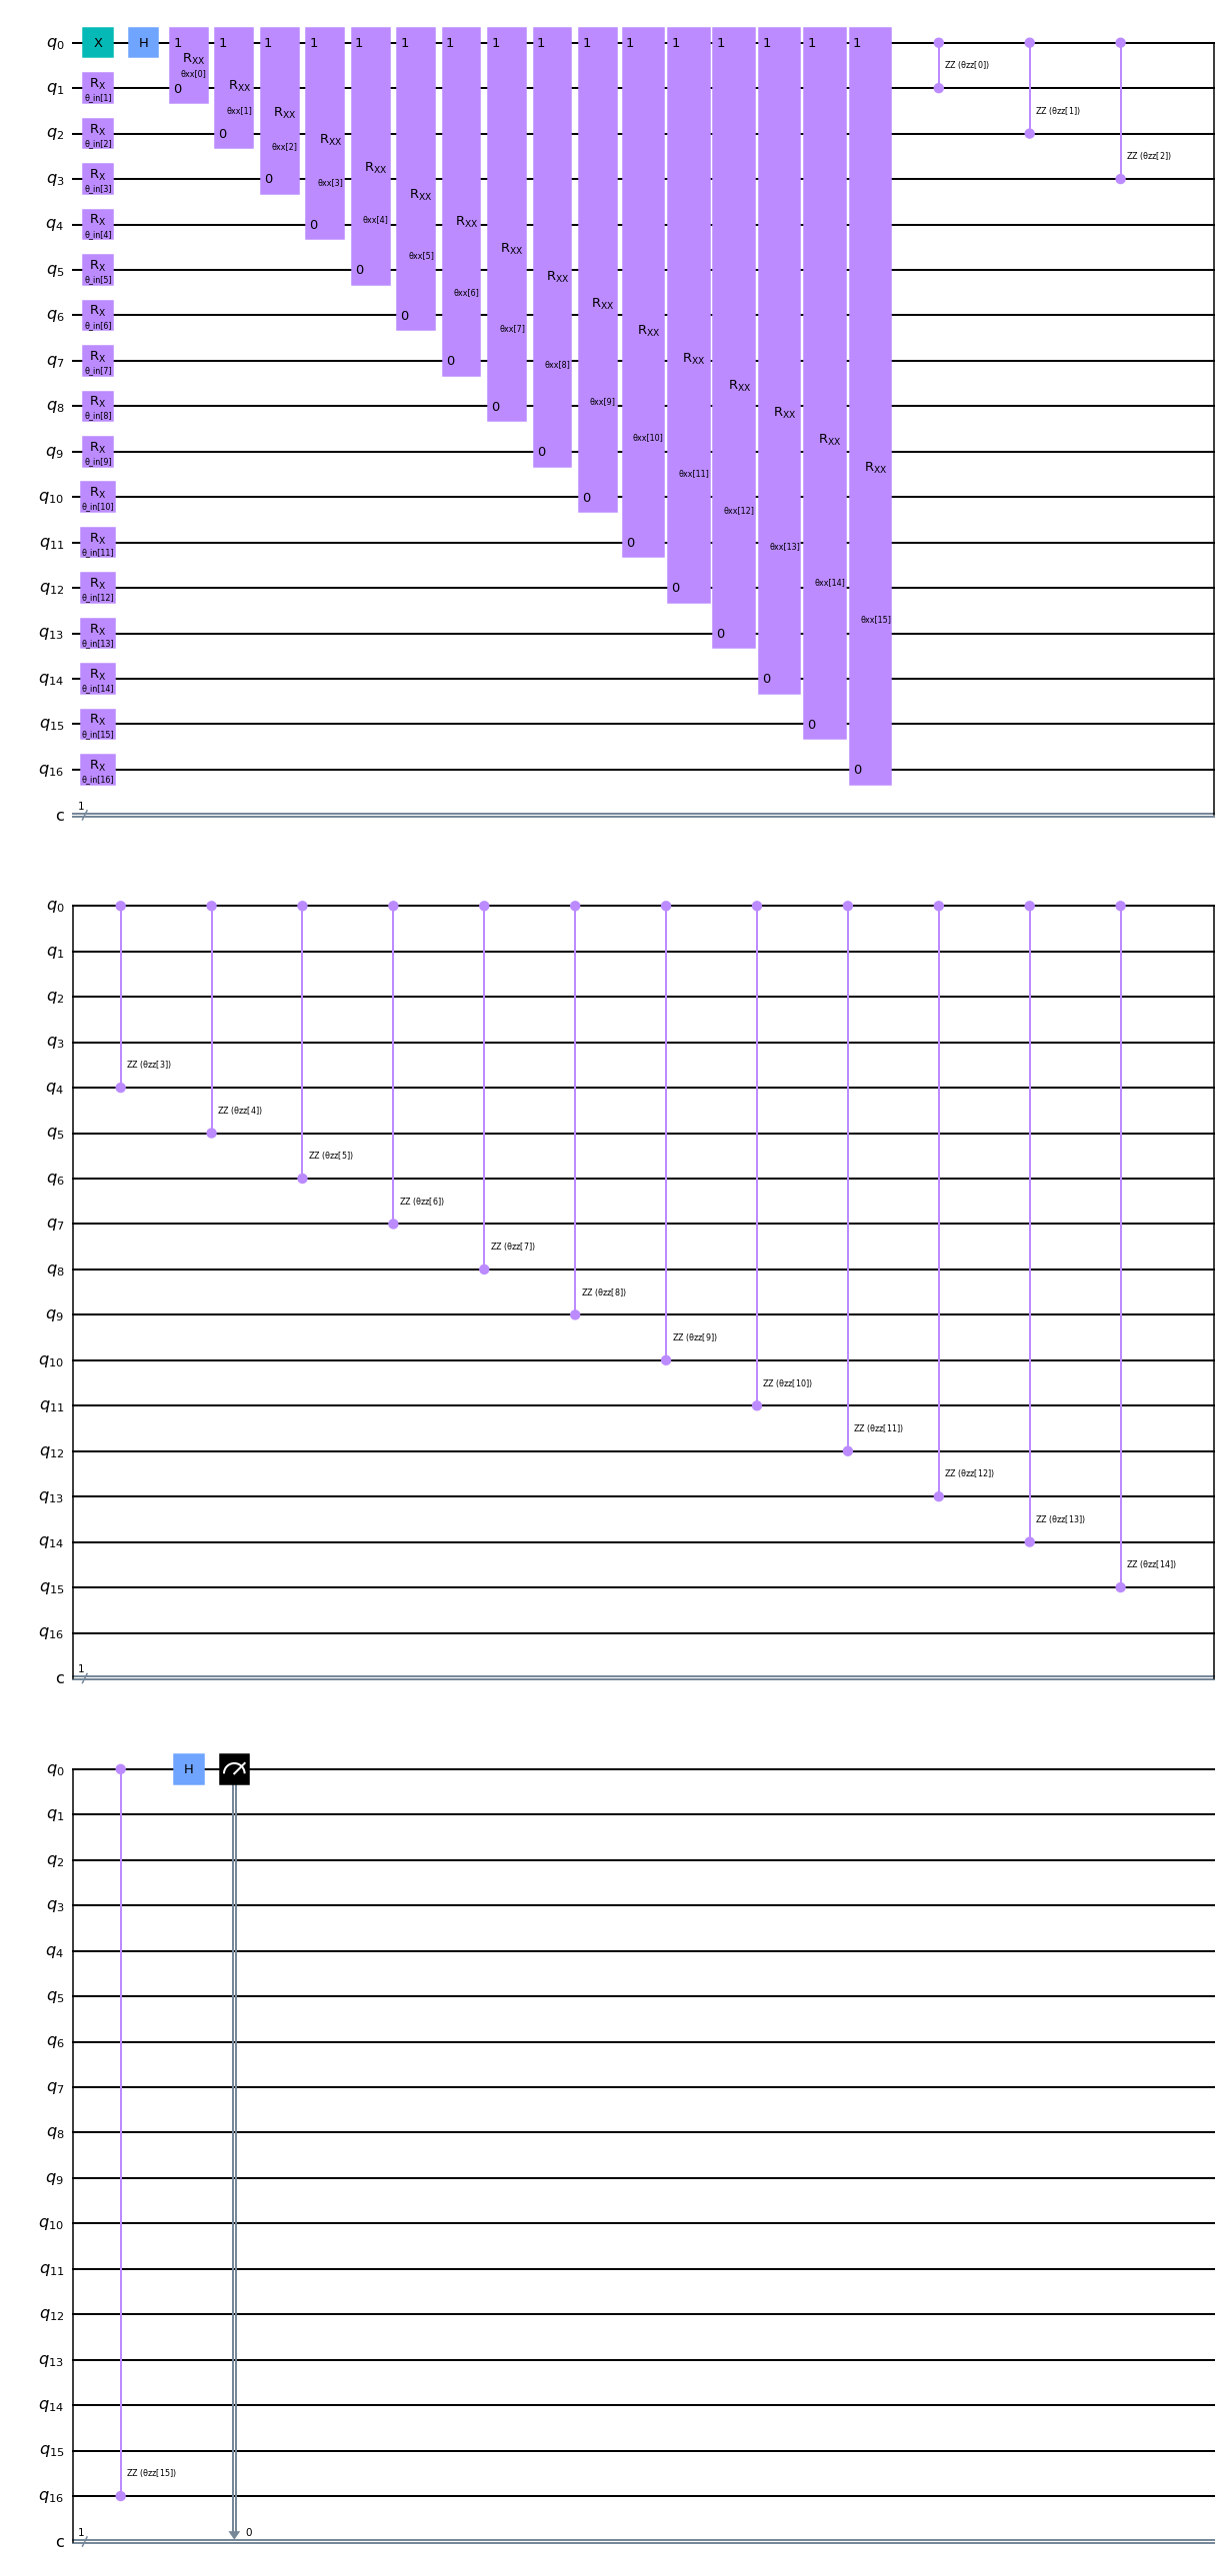

In [424]:
circuit.draw('mpl')

In [425]:
var_form.num_parameters

32

In [426]:
def circuit_parameters(x, variational):
    parameters = {}
    for i, p in enumerate(feature_map.parameters):
        parameters[p] = x[i]
    for i, p in enumerate(var_form.parameters):
        parameters[p] = variational[i]
    return parameters

In [427]:
def assign_label(bitstring):
    hamming_weight = sum([int(k) for k in list(bitstring)])
    odd = hamming_weight & 1
    if odd:
        return 1
    else:
        return 0

In [428]:
def label_probability(results):
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = assign_label(bitstring)
        probabilities[label] += counts / shots
    return probabilities

In [429]:
def classification_probability(data, variational):
    qc_list = [circuit.assign_parameters(circuit_parameters(d,variational)) for d in data]
    results =  execute(qc_list, backend).result()
    classification = [label_probability(results.get_counts(c)) for c in qc_list]
    return classification

In [430]:
costs = []
accuracies = []

In [431]:
def cross_entropy_loss(predictions, expected):
    p = predictions.get(expected)
    return -(expected*np.log(p)+(1-expected)*np.log(1-p))

def cost_function(data, labels, variational):
    classifications = classification_probability(data, variational)
    cost = 0
    predictions = []
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
        if classification[0] > classification[1]:
            predictions.append(0)
        else:
            predictions.append(1)
    cost /= len(data)
    costs.append(cost)
    acc = sum(predictions == labels)/len(labels)
    accuracies.append(acc)
    print('cost:', np.around(cost,4), 'acc: ',np.around(acc, 4))
    return cost

In [432]:
optimizer = COBYLA(maxiter=100)

initial_point = np.random.random(circuit.num_parameters)

objective_function = lambda variational: cost_function(x_train,
                                                       y_train,
                                                       variational)

In [433]:
# Run the optimization
opt_var, opt_value, _ = optimizer.optimize(len(initial_point), objective_function, initial_point=initial_point)

cost: 0.8061 acc:  0.4
cost: 0.7738 acc:  0.59
cost: 0.7506 acc:  0.67
cost: 0.5728 acc:  0.57
cost: 0.5626 acc:  0.5
cost: 0.5443 acc:  0.47
cost: 0.5383 acc:  0.48
cost: 0.5157 acc:  0.46
cost: 0.511 acc:  0.49
cost: 0.5343 acc:  0.47
cost: 0.5557 acc:  0.49
cost: 0.5434 acc:  0.47
cost: 0.5389 acc:  0.45
cost: 0.5134 acc:  0.49
cost: 0.5243 acc:  0.47
cost: 0.5101 acc:  0.49
cost: 0.5202 acc:  0.48
cost: 0.6353 acc:  0.52
cost: 0.6448 acc:  0.48
cost: 0.7804 acc:  0.37
cost: 0.6635 acc:  0.53
cost: 0.6871 acc:  0.51
cost: 0.6274 acc:  0.49
cost: 0.668 acc:  0.48
cost: 0.7534 acc:  0.66
cost: 0.6467 acc:  0.5
cost: 0.6549 acc:  0.43
cost: 0.6521 acc:  0.5
cost: 0.6568 acc:  0.49
cost: 0.6339 acc:  0.49
cost: 0.6494 acc:  0.48
cost: 0.6292 acc:  0.47
cost: 0.6503 acc:  0.46
cost: 0.514 acc:  0.48
cost: 0.5175 acc:  0.48
cost: 0.507 acc:  0.48
cost: 0.5091 acc:  0.49
cost: 0.5117 acc:  0.48
cost: 0.5081 acc:  0.49
cost: 0.51 acc:  0.49
cost: 0.5086 acc:  0.49
cost: 0.5104 acc:  0.49
co

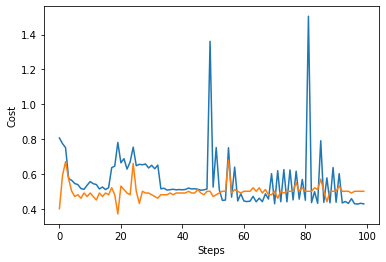

In [434]:
fig = plt.figure()
plt.plot(costs)
plt.plot(accuracies)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [435]:
def score_classifier(data, labels, variational):
    probability = classification_probability(data, variational)

    prediction = [0 if p[0] >= p[1] else 1 for p in probability]
    
    accuracy = 0
    for i, p in enumerate(probability):
        if (p[0] >= p[1]) and (labels[i] == 0):
            accuracy += 1
        elif (p[1]) >= p[0] and (labels[i] == 1):
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

accuracy, prediction = score_classifier(x_test, y_test, opt_var)
accuracy

0.5